## Logistic Regression

In logistic regression, the response variable follows a Bernoulli distribution representing a binary outcome (e.g., success or failure). The systematic component is represented by a linear predictor, and the link function used is the logistic function (also known as the logit function).

### Bernoulli Distribution

The Bernoulli distribution models a binary response variable, which takes only two possible outcomes: 0 or 1. The probability mass function (PMF) of the Bernoulli distribution is given by:

$$P(Y = y) = \begin{cases} 
p & \text{if } y = 1 \\
1-p & \text{if } y = 0 
\end{cases}$$

where $p$ is the probability of the positive outcome (e.g., $P(Y = 1)$) and $(1-p)$ is the probability of the negative outcome (e.g., $P(Y = 0)$).

### Binary classification
In a binary classification problem where the output $Y$ can take on two values (0 or 1), it is indeed natural to model $Y$ as a Bernoulli random variable. 

In this case, the probability mass function of $Y$ given the parameters $p$ is:

$$
p(y|p) = p^y (1-p)^{1-y}
$$

We can express this in the exponential family form as:

$$
p(y|\theta) = \exp(y \theta - \log(1+e^\theta))
$$

where $\theta = \log(\frac{p}{1-p})$ is the natural parameter of the exponential family, and $p = \frac{1}{1 + \exp(-\theta)}$ is the parameter of the Bernoulli distribution.

In a generalized linear model (GLM), we assume that the natural parameter $\theta$ is related to the features $X$ and parameters $\beta$ through a linear predictor function:

$$
\theta = X^T \beta = \sum_{j=1}^k \beta_i x_j
$$

So the negative log-likelihood for this GLM is:

$$
LLH = \sum_{i=1}^n - y_i \theta_i + \log(1+e^{\theta_i})
$$

This is the log-likelihood for a GLM with a Bernoulli distribution for $Y$, which is suitable for a binary classification problem.

The gradient of the log-likelihood function with respect to the parameter $\beta_j$ for the whole dataset of $n$ samples will be is given by:

$$
\frac{\partial LLH}{\partial \beta_j} =\sum_{i=1}^n - y_i x_{i,j} + x_{i,j} (\frac{ e^{\theta_i} }{1 + e^{\theta_i}})
$$

**Note:** All logarighms that are used in formulas are natural logarithms.


In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext(master='local',appName="Linear Regression")
spark = SparkSession(sparkContext=sc)

### Generate data

In [15]:
from sklearn.datasets import make_blobs
from pandas import DataFrame
from matplotlib import pyplot
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt 

n_feature = 2 # the number of features
n_components = 2 # the number of clusters

max_iter = 4 # max iterations 
n=100000 # the number of total samples

ratio_positive = 0.5 # The classes ratio.
n_samples = [int(n*(1-ratio_positive)), int(n*ratio_positive)]
n_components = [1,1]
n_samples

# generate isotropic Gaussian blobs (data from mixture Gaussian distributions)
X, y = make_blobs(n_samples=n_samples, # the number of total samples
                  centers=None, # the number of clusters
                  n_features=n_feature, # the number of features
                  cluster_std = 1.5, # the std of each cluster
                  random_state=2) # 2

#### Plot the data

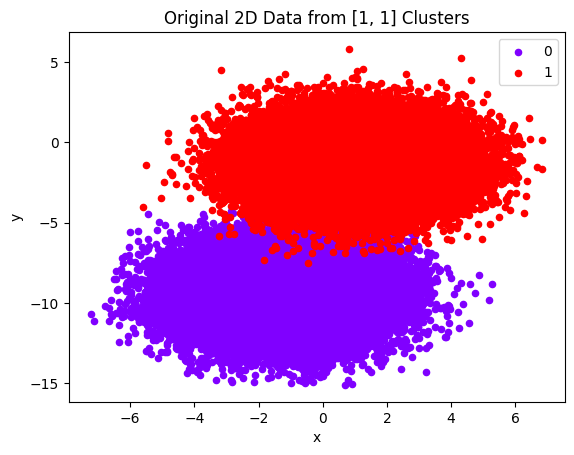

In [16]:
# Code for plotting the data
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0, 1, len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Original 2D Data from {} Clusters'.format(n_components))
pyplot.show()

#### Prepare the data in RDD

In [17]:
# read X, y into rdd
rdd_X = sc.parallelize(X)
rdd_y = sc.parallelize(y)

# split data into train and test
# Add: map(lambda x: (x[0],np.append(x[1],1)))
traindata, testdata = rdd_y.zip(rdd_X).randomSplit([0.8, 0.2], seed=12345)
traindata = traindata.map(lambda x: (x[0],np.append(x[1],1)))
traindata.cache()
train_size = traindata.count()
traindata.take(3)

[(0, array([-3.02457665, -9.92809418,  1.        ])),
 (0, array([-0.63099809, -8.30119281,  1.        ])),
 (0, array([ -0.86104732, -10.42137477,   1.        ]))]

# Gradient Descent Logistic Regression in PySpark

### GD Logistic Regression
$$
\theta = X^T \beta = \sum_{j=1}^k \beta_i x_j
$$

So the negative log-likelihood for this GLM is:

$$
LLH = \sum_{i=1}^n - y_i \theta_i + \log(1+e^{\theta_i})
$$

This is the log-likelihood for a GLM with a Bernoulli distribution for $Y$, which is suitable for a binary classification problem.

The gradient of the log-likelihood function with respect to the parameter $\beta_j$ for the whole dataset of $n$ samples will be is given by:

$$
\frac{\partial LLH}{\partial \beta_j} =\sum_{i=1}^n - y_i x_{i,j} + x_{i,j} (\frac{ e^{\theta_i} }{1 + e^{\theta_i}})
$$

In [18]:
learningRate = 1
num_iteration = 10

# Calculate the dimensionality of the inpit data
d_input = len(traindata.first()[1])

beta = np.ones(d_input) # initialize beta, ones are better than zeros for this case

print(f"Input dimensionalyty is {d_input} and we start wiht {beta} as parameters ")

# The main iterative part of gradient descent algorithm 
for i in range(num_iteration):

    gradientAndCost=traindata.map(lambda x: (x[1]*(-x[0]+np.exp(np.dot(x[1],beta))/(1+np.exp(np.dot(x[1],beta)))),
                                             -x[0]*np.dot(x[1],beta) + np.log(1+ np.exp(np.dot(x[1],beta)))))\
        .reduce(lambda x, y: (x[0] +y[0], x[1]+y[1] ))
    cost= gradientAndCost[1]/float(train_size)
    gradient=(1/float(train_size))* gradientAndCost[0]
    beta = beta - learningRate * gradient
    print(f"{i} Cost:{cost:.5f} Beta {beta}")
# Save the model parameters so we can eveluate the model on the test dataset.
parameter_vector_sgd = beta

Input dimensionalyty is 3 and we start wiht [1. 1. 1.] as parameters 
0 Cost:0.39318 Beta [1.0422908  0.58544591 1.19857529]
1 Cost:0.22502 Beta [1.01932415 0.3795796  1.32833569]
2 Cost:0.19500 Beta [0.97303494 0.49256977 1.40133435]
3 Cost:0.18604 Beta [0.94190445 0.41267035 1.50019101]
4 Cost:0.17620 Beta [0.90501213 0.49752942 1.57038168]
5 Cost:0.16858 Beta [0.87870514 0.44288834 1.65882506]
6 Cost:0.16098 Beta [0.8496295  0.5062694  1.72607133]
7 Cost:0.15456 Beta [0.82785818 0.47123762 1.80572667]
8 Cost:0.14845 Beta [0.80510817 0.51696015 1.87020244]
9 Cost:0.14303 Beta [0.78726621 0.4976153  1.94232412]


### GD Logistic Regression v2
Use the np.exp(np.dot(x[1],beta)) as a precomputed expression

In [19]:
learningRate = 1
num_iteration = 10

# Calculate the dimensionality of the inpit data
d_input = len(traindata.first()[1])
beta = np.ones(d_input)
print(f"Input dimensionalyty is {d_input} and we start wiht {beta} as parameters ")

# The main iterative part of gradient descent algorithm 
for i in range(num_iteration):
    gradientAndCost=traindata.map(lambda x: (x[0],x[1],np.exp(np.dot(x[1],beta))))\
        .map(lambda x: ( x[1]*(-x[0]+x[2]/(1+x[2])),
                        -x[0]*np.dot(x[1],beta) + np.log(1+ x[2])))\
        .reduce(lambda x, y: (x[0] +y[0], x[1]+y[1] ))
    cost= gradientAndCost[1]/float(train_size)
    gradient=(1/float(train_size))* gradientAndCost[0]
    beta = beta - learningRate * gradient
    print(f"{i} Cost:{cost:.5f} Beta {beta}")

Input dimensionalyty is 3 and we start wiht [1. 1. 1.] as parameters 
0 Cost:0.39318 Beta [1.0422908  0.58544591 1.19857529]
1 Cost:0.22502 Beta [1.01932415 0.3795796  1.32833569]
2 Cost:0.19500 Beta [0.97303494 0.49256977 1.40133435]
3 Cost:0.18604 Beta [0.94190445 0.41267035 1.50019101]
4 Cost:0.17620 Beta [0.90501213 0.49752942 1.57038168]
5 Cost:0.16858 Beta [0.87870514 0.44288834 1.65882506]
6 Cost:0.16098 Beta [0.8496295  0.5062694  1.72607133]
7 Cost:0.15456 Beta [0.82785818 0.47123762 1.80572667]
8 Cost:0.14845 Beta [0.80510817 0.51696015 1.87020244]
9 Cost:0.14303 Beta [0.78726621 0.4976153  1.94232412]


#### Prepare test data

In [20]:
# Test data need to be in the same format as the train data
testdata1 = testdata.map(lambda x: (x[0],np.append(x[1],1)))
test_num = testdata1.count()
testdata1.take(3)

[(0, array([ -0.9911372 , -10.01991492,   1.        ])),
 (1, array([ 3.01965824, -0.06047878,  1.        ])),
 (1, array([ 0.10996697, -3.83318403,  1.        ]))]

In [21]:
# Parameter vector size and test sample size must match.
print(parameter_vector_sgd)

[0.78726621 0.4976153  1.94232412]


## Evaluation of Binary Classifiers
In machine learning, binary classification is the task of classifying elements of a given input into two groups, based on a classification rule. Here, we will define:

    - True Positives (TP): These are cases in which we predicted yes, and the actual output is also yes.
    - True Negatives (TN): We predicted no, and the actual output is no.
    - False Positives (FP): We predicted yes, but the actual output is no.
    - False Negatives (FN): We predicted no, but the actual output is yes.

The most common metrics for evaluating binary classification models are:
- **Accuracy** is the proportion of true results among the total number of cases examined. It's calculated as follows:

$$ \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}} $$

- **Precision**, also known as the positive predictive value, measures the proportion of positive predictions that are actually correct.

$$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} $$

- **Recall**, also known as sensitivity, hit rate, or true positive rate (TPR), measures the proportion of actual positives that are correctly identified.

$$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$

- **The F1 Score** is the harmonic mean of precision and recall, aiming to balance these two values.

$$ \text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} $$


In [22]:
# Create an RDD with the true value and the predicted value (true, predicted)
predictions = testdata1.map(lambda x: (x[0], 1 if np.dot(x[1],parameter_vector_sgd)>0 else 0))

# predictions = (1, 1) (0, 1) ...
#               1 , 0, 

true_positive = predictions.map(lambda x: 1 if (x[0]== 1) and (x[1]==1) else 0).reduce(lambda x,y:x+y)
false_positive = predictions.map(lambda x: 1 if (x[0]== 0) and (x[1]==1) else 0).reduce(lambda x,y:x+y)

true_negative = predictions.map(lambda x: 1 if (x[0]== 0) and (x[1]==0) else 0).reduce(lambda x,y:x+y)
false_negative = predictions.map(lambda x: 1 if (x[0]== 1) and (x[1]==0) else 0).reduce(lambda x,y:x+y)

# Print the Contingency matrix
print("--Contingency matrix--")
print(f" TP:{true_positive:6}  FP:{false_positive:6}")
print(f" FN:{false_negative:6}  TN:{true_negative:6}")
print("----------------------")

# Calculate the Accuracy and the F1
accuracy = (true_positive+true_negative)/(test_num)
f1 = true_positive/(true_positive+0.5*(false_positive+false_negative))
print(f"Accuracy = {accuracy}  \nF1 = {f1}")

--Contingency matrix--
 TP:  9380  FP:    33
 FN:   632  TN:  9930
----------------------
Accuracy = 0.9667083854818523  
F1 = 0.9657657657657658


### GD Linear Regression

While linear regression is not naturally a classifier, it can be used for classification tasks with some adjustments. 

For Binary Classification you can threshold the output of a linear regression to turn it into a binary classifier. If the output of the linear regression is greater than a certain value, you can assign the instance to one class, otherwise you assign it to the other class. However, this approach has a major limitation because it assumes that the boundary between the classes is linear and it does not output probabilities. 

This is an example on how the linear regression can be used for classification problem. We can see that the results are not good, but if we continue the training for 140 iteration we will get comarable results with the Logistic regression. The tresold is set to 0.5.

In [25]:
learningRate = 0.04
num_iteration = 10

# Calculate the dimensionality of the inpit data
d_input = len(traindata.first()[1])
beta = np.zeros(d_input)
# This are model prameters after given number of iterations
# beta = [0.12538737, 0.03139575, 0.50380573] # 50
# beta = [0.0953784,  0.0520381,  0.67195052] # 80
# beta = [0.07446172, 0.06680653, 0.78809943] # 110
beta = [0.06001994, 0.07721533, 0.86837511] # 140
print(f"Input dimensionalyty is {d_input} and we start wiht {beta} as parameters ")
# The main iterative part of gradient descent algorithm 
for i in range(num_iteration):
    gradientAndCost=traindata.map(lambda x: (x[1], (x[0] - np.dot(x[1] , beta) )))\
                           .map(lambda x: (x[0]*x[1], x[1]**2 ))\
                           .reduce(lambda x, y: (x[0] +y[0], x[1]+y[1] ))
    cost= gradientAndCost[1]/train_size
    gradient=(-1/float(train_size))* gradientAndCost[0]
    beta = beta - learningRate * gradient
    print(f"{i} Cost:{cost:.5f} Beta {beta}")
# Save the model parameters so we can eveluate the model on the test dataset.
parameter_vector_lin_reg = beta

Input dimensionalyty is 3 and we start wiht [0.06001994, 0.07721533, 0.86837511] as parameters 
0 Cost:0.03809 Beta [0.05957449 0.07708303 0.87062063]
1 Cost:0.03783 Beta [0.05923415 0.07778624 0.87274527]
2 Cost:0.03759 Beta [0.05880117 0.07767091 0.87493467]
3 Cost:0.03735 Beta [0.0584675  0.07834367 0.87700916]
4 Cost:0.03711 Beta [0.0580466  0.07824411 0.87914389]
5 Cost:0.03688 Beta [0.05771954 0.07888792 0.88116937]
6 Cost:0.03666 Beta [0.05731033 0.07880302 0.88325083]
7 Cost:0.03644 Beta [0.05698979 0.07941929 0.88522841]
8 Cost:0.03623 Beta [0.05659192 0.07934801 0.88725798]
9 Cost:0.03602 Beta [0.05627783 0.07993808 0.88918874]


### Evaluation of Linear regression for Binary Classification

In [26]:
# Create an RDD wiht the true value and the predicted value (true, predicted)
predictions = testdata1.map(lambda x: (x[0], 1 if np.dot(x[1],parameter_vector_lin_reg)>0.5 else 0))

# predictions = (1, 1) (0, 1) ...
#               1 , 0, 

true_positive = predictions.map(lambda x: 1 if (x[0]== 1) and (x[1]==1) else 0).reduce(lambda x,y:x+y)
false_positive = predictions.map(lambda x: 1 if (x[0]== 0) and (x[1]==1) else 0).reduce(lambda x,y:x+y)

true_negative = predictions.map(lambda x: 1 if (x[0]== 0) and (x[1]==0) else 0).reduce(lambda x,y:x+y)
false_negative = predictions.map(lambda x: 1 if (x[0]== 1) and (x[1]==0) else 0).reduce(lambda x,y:x+y)

# Print the Contingency matrix
print("--Contingency matrix--")
print(f" TP:{true_positive:6}  FP:{false_positive:6}")
print(f" FN:{false_negative:6}  TN:{true_negative:6}")
print("----------------------")

# Calculate the Accuracy and the F1
accuracy = (true_positive+true_negative)/(test_num)
f1 = true_positive/(true_positive+0.5*(false_positive+false_negative))
print(f"Accuracy = {accuracy}  \nF1 = {f1}")

--Contingency matrix--
 TP:  9911  FP:    12
 FN:   101  TN:  9951
----------------------
Accuracy = 0.9943429286608261  
F1 = 0.9943315776272887


## GD Logistic Regression with treeAggregate
Example of implementation of Logistic regression using treeAggregate function

In [27]:
learningRate = 1
num_iteration = 10

# Calculate the dimensionality of the inpit data
d_input = len(traindata.first()[1])
beta = np.zeros(d_input)
print(f"Input dimensionalyty is {d_input} and we start wiht {beta} as parameters ")

# Let's start with main iterative part of gradient descent algorithm 
for i in range(num_iteration):
    gradientAndCost = traindata.map(lambda x: (x[0],x[1],np.dot(x[1],beta)))\
            .treeAggregate(
              (np.zeros(d_input), 0),
              lambda x, y:(x[0]+y[1]*(-y[0]+np.exp(y[2])/(1+np.exp(y[2]))),\
                           x[1]-y[0]*y[2]+np.log(1+np.exp(y[2]))),
              lambda x, y:(x[0] + y[0], x[1] + y[1])
              )
    #print(gradientAndCost)
    cost= gradientAndCost[1]/train_size
    gradient=(1/float(train_size))* gradientAndCost[0]
    beta = beta - learningRate * gradient
    print(f"{i} Cost:{cost:.5f} Beta {beta}")


Input dimensionalyty is 3 and we start wiht [0. 0. 0.] as parameters 
0 Cost:0.69315 Beta [ 5.71485164e-01  2.04585091e+00 -3.06154327e-04]
1 Cost:1.36368 Beta [0.87133316 1.36834978 0.3581195 ]
2 Cost:0.74633 Beta [1.03071551 0.7959134  0.64423232]
3 Cost:0.38101 Beta [1.06095096 0.40912264 0.8441319 ]
4 Cost:0.24381 Beta [1.02579227 0.33043639 0.96632569]
5 Cost:0.23014 Beta [0.98196739 0.44388477 1.05545848]
6 Cost:0.21916 Beta [0.95400811 0.35366554 1.1707797 ]
7 Cost:0.20728 Beta [0.91705439 0.47245008 1.25045558]
8 Cost:0.19838 Beta [0.89475673 0.37977346 1.35826709]
9 Cost:0.18798 Beta [0.86420756 0.49292609 1.43087068]


# SVM implementation in PySpark

In [28]:
learningRate = 0.2
num_iteration = 10
# Transform the data for the SVM
traindataSVM = traindata.map(lambda x: (1 if x[0]==1 else -1, x[1]))
# Calculate the dimensionality of the input data
d_input = len(traindataSVM.first()[1])
weights = np.zeros(d_input)
print(f"Input dimensionality is {d_input} and we start with {weights} as parameters ")

# Let's start with the main iterative part of the gradient descent algorithm
for i in range(num_iteration):
    gradientAndCost = traindataSVM.map(lambda x: ((-x[0] * x[1]) if (x[0] * np.dot(x[1], weights)) < 1 else np.zeros(d_input),
                                max(0, 1 - x[0] * np.dot(x[1], weights))))\
            .reduce(lambda x, y: (x[0] +y[0], x[1]+y[1] ))

    cost= gradientAndCost[1]/float(train_size)
    gradient=(1/float(train_size))* gradientAndCost[0]
    weights =weights - learningRate * gradient
    print(f"{i} Cost:{cost:.5f} weights {weights}")

Input dimensionality is 3 and we start with [0. 0. 0.] as parameters 
0 Cost:1.00000 weights [ 2.28594065e-01  8.18340363e-01 -1.22461731e-04]
1 Cost:0.93770 weights [0.31574184 0.67796984 0.09245611]
2 Cost:0.76003 weights [0.39619507 0.53768348 0.18313777]
3 Cost:0.59165 weights [0.46456715 0.39935094 0.27010309]
4 Cost:0.44102 weights [0.51387697 0.26844392 0.35059294]
5 Cost:0.32217 weights [0.53667283 0.16600425 0.42009622]
6 Cost:0.27479 weights [0.5304867  0.20743975 0.46645173]
7 Cost:0.26259 weights [0.52981975 0.17669127 0.5206298 ]
8 Cost:0.24986 weights [0.51935732 0.22138449 0.5631965 ]
9 Cost:0.23912 weights [0.51568113 0.18748083 0.61487785]


In [29]:
# Create an RDD with the true value and the predicted value (true, predicted)
predictions = testdata1.map(lambda x: (x[0], 1 if np.dot(x[1],weights)>0 else 0))

# predictions = (1, 1) (0, 1) ...
#               1 , 0, 

true_positive = predictions.map(lambda x: 1 if (x[0]== 1) and (x[1]==1) else 0).reduce(lambda x,y:x+y)
false_positive = predictions.map(lambda x: 1 if (x[0]== 0) and (x[1]==1) else 0).reduce(lambda x,y:x+y)

true_negative = predictions.map(lambda x: 1 if (x[0]== 0) and (x[1]==0) else 0).reduce(lambda x,y:x+y)
false_negative = predictions.map(lambda x: 1 if (x[0]== 1) and (x[1]==0) else 0).reduce(lambda x,y:x+y)

# Print the Contingency matrix
print("--Contingency matrix--")
print(f" TP:{true_positive:6}  FP:{false_positive:6}")
print(f" FN:{false_negative:6}  TN:{true_negative:6}")
print("----------------------")

# Calculate the Accuracy and the F1
accuracy = (true_positive+true_negative)/(test_num)
f1 = true_positive/(true_positive+0.5*(false_positive+false_negative))
print(f"Accuracy = {accuracy}  \nF1 = {f1}")

--Contingency matrix--
 TP:  8647  FP:   142
 FN:  1365  TN:  9821
----------------------
Accuracy = 0.9245556946182728  
F1 = 0.9198446891122812
